Joshua Avakian
CSCI 191T
12pm - 12:50pm

In [14]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import math
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import itertools
import pandas as pd

In [15]:
X = np.array([
    0, 0,
    0, 1,
    1, 0,
    1, 1
]).reshape(4, 2)

R = np.array([0, 1, 1, 0]).reshape(4,)
Y = np.array([0, 1, 1, 0]).reshape(4,)

In [16]:
pca = PCA(n_components=2) 
Xred = pca.fit_transform(X) #transformed points
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))
print (pca.components_[0,:])
print (pca.components_[1,:])
print (Xred[0:3,:])

print ("Original Variance=", X.var(axis=0), sum(X.var(axis=0)))
print ("Projected Variance=", Xred.var(axis=0), sum(Xred.var(axis=0)))

[0.5 0.5] 1.0
[-1. -0.]
[-0. -1.]
[[ 0.5  0.5]
 [ 0.5 -0.5]
 [-0.5  0.5]]
Original Variance= [0.25 0.25] 0.5
Projected Variance= [0.25 0.25] 0.49999999999999994


## Models and Weight Vectors

In [17]:
np.random.seed(34) #change for different weight rand values

def F(W,X):
  return sum([w*x for w,x in zip(W,X)])
def xor(x1, x2):
    return bool(x1) != bool(x2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(sigmoid_result):
    return sigmoid_result * (1 - sigmoid_result)

def error(target, prediction):
    return .5 * (target - prediction)**2

def error_derivative(target, prediction):
    return - target + prediction
def classification(model, X):
  return [1 if sigmoid(F(model, x)) > 0.5 else 0 for x in X]


Q= lambda w, a: w[0]*a[0] + w[1]*a[1] + w[2]*a[2] + w[3]*a[3]
Xcen = X - X.mean(axis=0) #subtract mean from every x
print ("Means=", X.mean(axis=0)) 
print (X[0,:]) 
print ("Xcen=", Xcen[0,:])
print (pca.components_[0,:])
print (F(pca.components_[0,:],Xcen[0,:]))
print (F(pca.components_[1,:],Xcen[0,:]))
print (Xred[0,:])


Means= [0.5 0.5]
[0 0]
Xcen= [-0.5 -0.5]
[-1. -0.]
0.5
0.5
[0.5 0.5]


# First Accuracy Prediction

In [18]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(Xred[:,0].reshape(-1, 1), R)
predict = lr.predict(Xred[:,0].reshape(-1, 1))
print ("Variance=", Xred[:,0].reshape(-1, 1).var(axis=0), sum(Xred[:,0].reshape(-1, 1).var(axis=0)))
print("Accuracy = ", accuracy_score(predict, R))

Variance= [0.25] 0.25
Accuracy =  0.5


#Back Propagation

In [19]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[xor(*i)] for i in x], dtype=int)

alpha = 0.02 #learning rate
print('Learning Rate:', alpha)

n_neurons_input, n_neurons_hidden, n_neurons_output = 2, 2, 1

w_hidden = np.random.random(size=(n_neurons_input, n_neurons_hidden))
b_hidden = np.random.random(size=(1, n_neurons_hidden))

w_output = np.random.random(size=(n_neurons_hidden, n_neurons_output))
b_output = np.random.random(size=(1, n_neurons_output))

Learning Rate: 0.02


#Iterations

In [20]:
errors = []
params = []
grads = []
while True:
    # forward propigation
    y_hidden = sigmoid(np.dot(x, w_hidden) + b_hidden)
    y_output = sigmoid(np.dot(y_hidden, w_output) + b_output)

    # calculate mean error for all the errors for the epoch
    e = error(y, y_output).mean()
    if e < 1e-4:
        break

    # back propigation
    grad_output = error_derivative(y, y_output) * sigmoid_derivative(y_output)
    grad_hidden = grad_output.dot(w_output.T) * sigmoid_derivative(y_hidden)
    # update parameters
    w_output -= alpha * y_hidden.T.dot(grad_output)
    w_hidden -= alpha * x.T.dot(grad_hidden)

    b_output -= alpha * np.sum(grad_output)
    b_hidden -= alpha * np.sum(grad_hidden)

    errors.append(e)
    grads.append(np.concatenate((grad_output.ravel(), grad_hidden.ravel())))
    params.append(np.concatenate((w_output.ravel(), b_output.ravel(),
                                  w_hidden.ravel(), b_hidden.ravel())))

In [21]:
def predict(x):
  y_hidden = sigmoid(np.dot(x, w_hidden) + b_hidden)
  return sigmoid(np.dot(y_hidden, w_output) + b_output)

#Check For Convergence

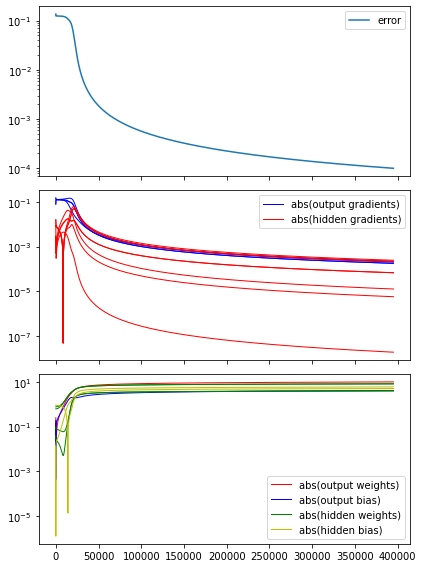

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True) 

pd.DataFrame(errors, columns=['error']).plot(ax=axes[0], logy=True)
df_grads = pd.DataFrame(grads)
df_params = pd.DataFrame(params)

for i in range(4):
    axes[1].plot(df_grads.iloc[:, i].abs(), c='b', label='abs(output gradients)' if i==1 else '__nolabel', lw=1)
for i in range(4, 12):
    axes[1].plot(df_grads.iloc[:, i].abs(), c='r', label='abs(hidden gradients)' if i==4 else '__nolabel', lw=1)

for i in range(1, 2):
    axes[2].plot(df_params.iloc[:, i].abs(), c='r', label='abs(output weights)' if i==1 else '__nolabel', lw=1)

axes[2].plot(df_params.iloc[:, 2].abs(), c='b', label='abs(output bias)', lw=1)

for i in range(3, 7):
    axes[2].plot(df_params.iloc[:, i].abs(), c='g', label='abs(hidden weights)' if i==3 else '__nolabel', lw=1)

for i in range(7, 9):
    axes[2].plot(df_params.iloc[:, i].abs(), c='y', label='abs(hidden bias)' if i==7 else '__nolabel', lw=1)

axes[1].legend()
axes[1].set_yscale('log')

axes[2].legend()
axes[2].set_yscale('log')

fig.tight_layout()

Result Plot:


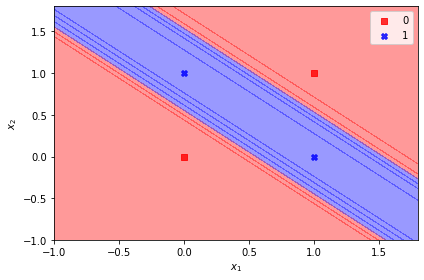

In [23]:
print("Result Plot:")

markers = ('s', 'X')
colors = ('red', 'blue')

x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.2),
                       np.arange(x2_min, x2_max, 0.2))

z = predict(np.array([xx1.ravel(), xx2.ravel()]).T)
z = z.reshape(xx1.shape)

fig, ax = plt.subplots()
ax.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors))
ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())

for idx, cl in enumerate(np.unique(y)):
    ax.scatter(x=x[(y == cl).ravel(), 0],
               y=x[(y == cl).ravel(), 1],
               alpha=0.8, c=colors[idx],
               marker=markers[idx], label=cl)
ax.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()

#Accuracy Prediction Again

In [24]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(Xred, R)
predict = lr.predict(Xred)
print ("Variance=", Xred.var(axis=0), sum(Xred.var(axis=0)))
print("Accuracy = ", accuracy_score(predict, R))

Variance= [0.25 0.25] 0.49999999999999994
Accuracy =  0.5


In [25]:
Xtrain = list(zip(x[: , 1], x[:,0]))
print (Xtrain)
lr = LogisticRegression(solver='lbfgs')
lr.fit(Xtrain, R)
predict = lr.predict(Xtrain)
print(accuracy_score(predict, R))

[(0, 0), (1, 0), (0, 1), (1, 1)]
0.5


#Squared Error

In [26]:
print(math.exp(e)) #e is taken from the iterations, and e is the mean of the errors
#it just needs to be squared to complete the squared error as e is the mean of the inputs and outputs

1.0001000047555575
